# Embedding + CNN을 이용한 감정 분석
## Process
1. 전처리된 데이터 불러오기
2. one_hot 인코딩
3. CNN 레이어 구성
4. 학습

## Reference
1. [케라스와 텐서플로 허브를 사용한 영화 리뷰 텍스트 분류하기](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub?hl=ko)
2. [keras를 이용해서, sequence classification 해보기](https://frhyme.github.io/machin-learning/sequence_classficiation/)

In [1]:
%matplotlib inline
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Embedding, Dropout, GlobalAveragePooling1D, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

Using TensorFlow backend.


In [2]:
data = pd.read_json("../data/news_reactions_recent_preprocessed.json")
data.head()

,title_token,content_token,reaction_category
0,"[전두환, 프로젝트, 연희동, 집, 가구, 세트, 막대, 세금, 구입, 네이버, 뉴스]","[대통령, 자리, 물러난, 전두환, 별도, 전직, 대통령, 사무실, 내지, 않았으면...",1
1,"[식약처, 존슨, 앤드, 존슨, 제품, 빼고, 암, 위험, 인공, 유방, 퇴, 출,...","[식품의약품안전처, 암, 발병, 사례, 보고, 된, 인공, 유방, 보, 형, 물이,...",1
10,"[늘어나는, 주택연금, 가입자, 집, 한, 채, 있다면, 노후, 걱정, 마세요, 네...","[주택연금, 올, 들어서만, 명, 가입, 정부, 주택연금, 가입, 기준, 완화, 예...",2
100,"[비서, 성폭행, 안희정, 심, 달랐던, 판단, 오늘, 대법, 선고, 네이버, 뉴스]","[앵커, 심, 무죄, 나왔지만, 심, 실형, 선고, 받고, 법정구속, 돼, 있습니다...",1
1000,"[인천, 경기, 북부, 호우, 주의보, 내일, 최고, 더, 온다, 네이버, 뉴스]","[아침, 인천, 경기, 북부, 파주, 고양, 연천, 김포, 안산, 호우, 주의보, ...",2


## 임베딩


In [3]:
# 상수 정하기
NUM_TOKENS = 10000   # 최대 임베딩 가능한 토큰의 수
EMBEDDING_SIZE = 256 # 임베딩 벡터의 크기
MAX_SEQUENCE_LEN = 1024   # 시퀀스 최대 길이
TITLE_MAX_LEN = 32 # 제목 토큰 최대길이
CONTENT_MAX_LEN = 1024 # 뉴스 내용 토큰 최대길이

WORD_PAD = '<pad>'
WORD_EOS = '<eos>'
WORD_UNK = '<unk>'

In [4]:
# 자주 사용된 토큰 순으로 토큰 개수를 제한함.
# 모든 토큰의 갯수, 많이 사용된 토큰 50개만 출력
token_counter = Counter()
for row in data.itertuples():
    token_counter.update(row[1])
    token_counter.update(row[2])
    
print(len(token_counter))
print(token_counter.most_common(50))

commons = token_counter.most_common(NUM_TOKENS - 3)
commons.insert(0, (WORD_PAD, 0))
commons.insert(1, (WORD_EOS, 0))
commons.insert(2, (WORD_UNK, 0))

word2idx = {w[0]: i for i, w in enumerate(commons)}

44565
[('했다', 11571), ('것', 10725), ('이', 8160), ('들', 7291), ('등', 5866), ('적', 5494), ('하는', 5422), ('있다', 5216), ('할', 5094), ('고', 4963), ('수', 4896), ('장관', 4516), ('해', 4005), ('검찰', 3609), ('말', 3373), ('된', 3323), ('재', 3124), ('뉴스', 3012), ('조', 2999), ('한국', 2998), ('대통령', 2971), ('기자', 2929), ('그', 2835), ('한', 2588), ('며', 2583), ('있는', 2515), ('네이버', 2510), ('전', 2506), ('조국', 2399), ('한다', 2320), ('명', 2294), ('임명', 2214), ('대한', 2168), ('미국', 2119), ('및', 1964), ('당', 1936), ('지난', 1921), ('대해', 1895), ('수사', 1852), ('의원', 1836), ('는', 1808), ('후보자', 1792), ('됐다', 1744), ('날', 1718), ('중', 1716), ('정부', 1634), ('위', 1608), ('금지', 1591), ('관련', 1575), ('될', 1565)]


In [5]:
X = []
y = []

EOS_IDX = word2idx[WORD_EOS]
PAD_IDX = word2idx[WORD_PAD]
UNK_IDX = word2idx[WORD_UNK]
Y_LABEL = list(map(lambda x: np.array(x), ([[1,0,0],[0,1,0],[0,0,1]])))

for row in data.itertuples():
    title = row[1]
    title_len = len(title)
    content = row[2]
    content_len = len(content)
    category = row[3]
    
    x = []
    title = list(map(lambda x: word2idx.get(x, UNK_IDX), title))
    content = list(map(lambda x: word2idx.get(x, UNK_IDX), content))
    
    if title_len >= TITLE_MAX_LEN:
        title = title[:TITLE_MAX_LEN]
    elif title_len < TITLE_MAX_LEN:
        title.extend([PAD_IDX for i in range(TITLE_MAX_LEN - title_len)])
    if content_len >= CONTENT_MAX_LEN:
        content = content[:CONTENT_MAX_LEN]
    elif content_len < CONTENT_MAX_LEN:
        title.extend([PAD_IDX for i in range(CONTENT_MAX_LEN - content_len)])
    
    x.extend(title)
    x.extend(content)
    
    if len(x) >= MAX_SEQUENCE_LEN:
        x = x[:MAX_SEQUENCE_LEN]
        
    X.append(np.array(x))
    y.append(Y_LABEL[category])

X = np.array(X)
y = np.array(y)

In [6]:
print(data.loc[2], X[2], len(X[2]))
print(y[2])

title_token                        [달걀, 견과류, 아침, 공복, 먹어야, 효과, 네이버, 뉴스]
content_token        [항산화제, 알려진, 비타민, E, 의, 흡수, 율, 높이려면, 아침식사, 때, 달...
reaction_category                                                    0
Name: 2, dtype: object [4575 5308 2179 ...  514  255  119] 1024
[0 0 1]


## Train-Test 분리

In [7]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

print("Train Size: ", len(train_x))
print("Test Size: ", len(test_x))

Train Size:  1841
Test Size:  461


In [8]:
train_y[0]

array([1, 0, 0])

## 모델 생성 및 학습

In [9]:
model = Sequential([
    Embedding(NUM_TOKENS, EMBEDDING_SIZE, input_shape=(None,)),
    Conv1D(filters=32, kernel_size=5, padding='same', activation='sigmoid'),
    MaxPooling1D(pool_size=2),
    LSTM(50),
    Dropout(0.2), 
    Dense(256, activation='sigmoid'), 
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          40992     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13056     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [ ]:
history = model.fit(train_x, train_y,
                    epochs=10,
                    batch_size=64,
                    validation_data=(test_x, test_y),
                    verbose=1)

# 결과

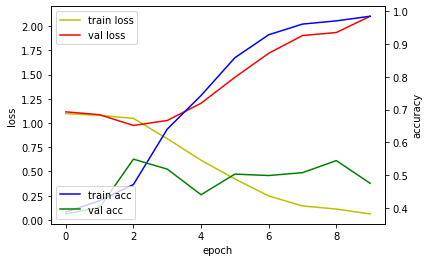

In [11]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='best')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='lower left')

plt.show()

In [12]:
# 모델을 저장합니다.
model.save("../model/emb_conv_lstm.h5")